In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plot_img

In [20]:
img = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/4_colab/train_ref/1.BMP', 0)
database_image = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/4_colab/test2_2/3_type1.BMP', 0)
height, width = img.shape[:2]


In [5]:

import matplotlib.pyplot as plt
def apply_Contrast(img):
    alpha = 0.5 
    beta = 0.5 
    img_second = np.zeros(img.shape, img.dtype) 
    contrast = cv2.addWeighted(img, alpha, img_second, 0, beta) 
    return contrast

In [6]:

def apply_Binarization(img):


    img_gauss = cv2.GaussianBlur(img, (3, 3), 0) # 가우스 노이즈 제거

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    mask = clahe.apply(img_gauss)

    img_adpt = cv2.adaptiveThreshold(mask, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 5)
    img_adpt = 255 - img_adpt

    plt.imshow(img_adpt, cmap='gray')
    return img_adpt


In [29]:

def apply_Erosion(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    img_res = img.copy()

    img_res = cv2.medianBlur(img_res, 3)
    img_res = cv2.morphologyEx(img_res, cv2.MORPH_CLOSE, kernel, iterations=1)
    img_res = cv2.medianBlur(img_res, 3)
    img_res = cv2.medianBlur(img_res, 3)

    plt.imshow(img_res, cmap='gray')

    return img_res

In [8]:

def apply_highlighting(img):
    feature_points = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    Image_blue = np.array(feature_points, copy=True)

    white_px = np.asarray([255, 255, 255])
    blue_px = np.asarray([0  , 255  , 255  ])

    (row, col, _) = feature_points.shape

    for r in range(row):
        for c in range(col):
            px = feature_points[r][c]
            if all(px == white_px):
                Image_blue[r][c] = blue_px
    
    return Image_blue


In [9]:

def show_featurepoints(img):
    
    #orb detector 이용...
    orb  = cv2.ORB_create(nfeatures=1200)
    keypoints, descriptors = orb.detectAndCompute(img, None)
    featurepoint_img = img
    featurepoint_img = cv2.drawKeypoints(featurepoint_img, keypoints, None, color=(255, 0 ,0))

    return featurepoint_img


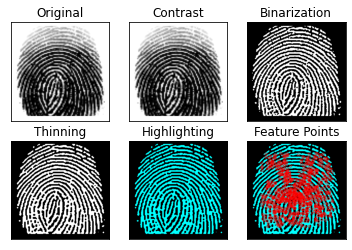

In [30]:
analyzed_image = img
contrast = apply_Contrast(img)
analyzed_image = contrast
mask = apply_Binarization(contrast)
analyzed_image = mask
erosion = apply_Erosion(mask)
analyzed_image = erosion
Image_blue = apply_highlighting(erosion)
featurepoint_img = show_featurepoints(Image_blue)

mask2 = apply_Binarization(database_image)
erosion2 = apply_Erosion(mask2)
Image_blue2 = apply_Binarization(erosion2)


process_done = ["Original", "Contrast","Binarization","Thinning", "Highlighting", "Feature Points"]
images = [img, contrast, mask, erosion, Image_blue, featurepoint_img]

for i in range(6):
    plot_img.subplot(2, 3, i+1), plot_img.imshow(images[i], 'gray')
    plot_img.title(process_done[i])
    plot_img.xticks([]),plot_img.yticks([])


In [31]:
orb  = cv2.ORB_create(nfeatures=50)

match_results_img = cv2.cvtColor(Image_blue, cv2.COLOR_RGB2BGR) 
match_results_img2 = cv2.cvtColor(Image_blue2, cv2.COLOR_RGB2BGR) 


keypoints_img1, des1 = orb.detectAndCompute(analyzed_image, None) 
keypoints_img2, des2 = orb.detectAndCompute(database_image, None) 

brute_f = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matchesOriginal = brute_f.match(des1, des1)  
matchesNew = brute_f.match(des1, des2)   

In [32]:

match_rate = (len(matchesNew)/len(matchesOriginal))*100     


In [33]:
matching_result = cv2.drawMatches(match_results_img, keypoints_img1, match_results_img2, keypoints_img2, matchesNew, None, matchColor=(0, 0 ,255))

In [34]:

match_height, match_width = img.shape[:2] 
b,g,r,a = 255,255,255,0
repeat_draw = 10 
for x in range(repeat_draw):
    cv2.putText(matching_result,"Match Rate: " + str(match_rate) + "%", ( int(match_width/2),int(match_height-10)), cv2.FONT_HERSHEY_SIMPLEX , 0.7, (b,g,r), 1, cv2.LINE_AA) 


In [35]:

b,g,r,a = 0,255,0,0
if match_rate > 90:
    for x in range(repeat_draw):
        cv2.putText(matching_result,"FINGERPRINT MATCH FOUND.", ( int(match_width/2)-30,int(match_height-30)), cv2.FONT_HERSHEY_SIMPLEX , 0.7, (b,g,r), 1, cv2.LINE_AA) 
else:
    for x in range(repeat_draw):
        cv2.putText(matching_result,"NO MATCH FOUND.", ( int(match_width/2),int(match_height-30)), cv2.FONT_HERSHEY_SIMPLEX , 0.7, (b,g,r), 1, cv2.LINE_AA) 

In [27]:
import matplotlib.pyplot as plt

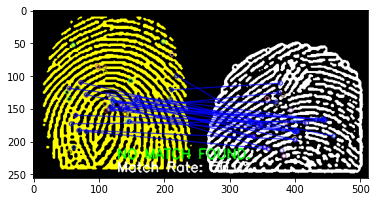

In [36]:
plt.imshow(matching_result, cmap='gray')


<Figure size 612x432 with 0 Axes>

# **시도....**

필터 넣어보고자 했지만 어떤식으로 넣어야할지 모르겠어서 넣지 못함

In [ ]:
%%time
ks = 3
kernel = np.ones((ks, ks)) / (ks*ks)
print(kernel)

rows, cols = img1.shape[:2]
print(rows, cols)
img_filtered = np.zeros(img1.shape, dtype=np.uint8)

for i in tqdm(range(1,rows-1)):
        for j in range(1,cols-1):
            result = 0
            for k_i in range(0, len(kernel)):
                for k_j in range(0, len(kernel[0])):
                    # result += img1[i, j] * kernel[k_i, k_j]  # correlation
                    result += img1[i-ks//2+k_i, j-ks//2+k_j] * kernel[(len(kernel)-1)-k_i, (len(kernel)-1)-k_j] 
            img_filtered[i, j] = int(result)

print(img1.max(), img_filtered.max())

plt.imshow(cv2.cvtColor(img_filtered, cv2.COLOR_GRAY2RGB))

In [ ]:

orb = cv2.ORB_create(50)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

다른방식으로 feature 추출 후 비교?

In [ ]:
def get_feature_descriptors(dataset):
    feature_descriptors = {}
    for image_id, image in dataset.items():
        kp, des = orb.detectAndCompute(image, None)
        feature_descriptors[image_id] = des
    return feature_descriptors

In [ ]:
def get_best_matches(query_image, trained_features, distance_threshold): 
    best_matches_dict = {}
    kp1, query_des = orb.detectAndCompute(query_image, None) 
    for train_image_id, trained_feature_des in trained_features.items():
        if query_des is not None and trained_feature_des is not None:
            matches = bf.match(query_des, trained_feature_des)
            matches.sort(key=lambda x: x.distance, reverse=False) 
            
            best_matches = [m.distance for m in matches if m.distance < distance_threshold]
            best_matches_dict[train_image_id] = len(best_matches) 
    
    best_matches_dict = sorted(best_matches_dict.items(), key = operator.itemgetter(1), reverse=True)
    return best_matches_dict

Convex Hull - Scikit-image도 써보고 싶었는데 감이 안잡혀서 사용해보지 못함... 지문부분만 둥그렇게 인식하지 못하고 사진 전체를 인식함